对于h个注意力汇聚，每个注意力汇聚都被称为是一个头

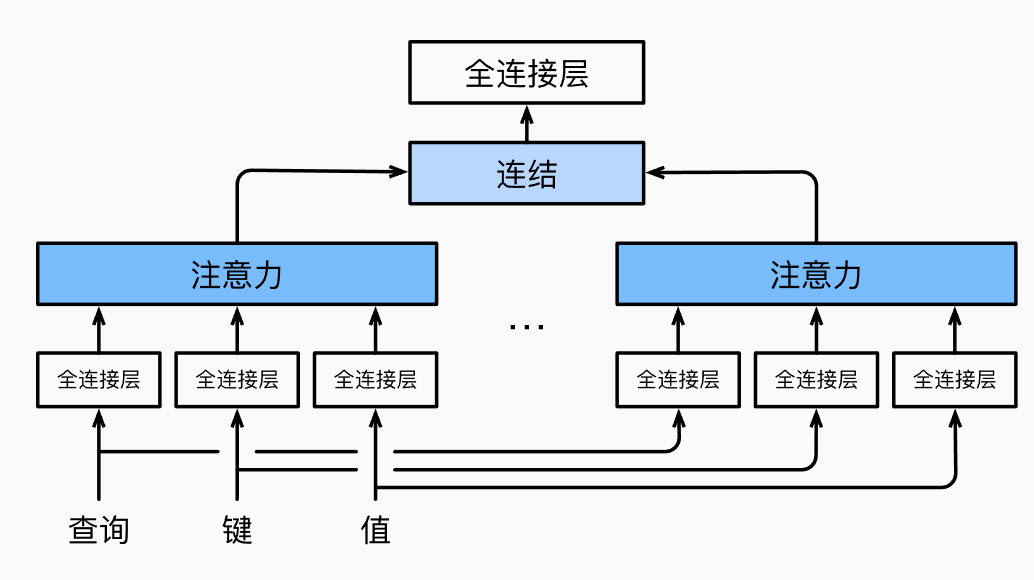

每个头可能会关注输入的不同部分，可以表示比简单加权平均更复杂的函数

In [20]:
import math
import torch
from torch import nn
from d2l import torch as d2l

每一个注意力头选择缩放点积注意力

In [21]:
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [22]:
class MultiHeadAttention(nn.Module):
    '''多头注意力'''
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状: (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状: (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)        
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            # 在轴0，将第一项复制num_heads次
            # 然后如此复制第二项，然后诸如此类
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

下面使用键和值相同的小例子来测试我们编写的MultiHeadAttention类。 多头注意力输出的形状是（batch_size，num_queries，num_hiddens）。

In [23]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [26]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
X
Y
valid_lens.shape
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])